In [6]:
import sys
sys.path.append('../_amigocloud')
import simplekml
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import os

In [7]:
def get_unidad_local():
    try:
        # ruta del archivo que contiene la información necesaria
        with open('../../unidad_local.txt', 'r') as file:
            unidad = file.readline().strip()
            return unidad
    except FileNotFoundError:
        print("El archivo 'unidad_local.txt' no se encuentra en la ruta especificada.")
    return None

def get_ruta_local():
    try:
        with open('../ruta_local.txt', 'r') as file:
            ruta = file.readline().strip()
            return ruta
    except FileNotFoundError:
        print("El archivo 'ruta_local.txt' no se encuentra en la ruta especificada.")
    return None

In [8]:
ors = 17

In [9]:
# RUTA ONEDRIVE
unidad = get_unidad_local()
ruta = get_ruta_local()
ruta_completa = os.path.join(unidad, ruta)
ruta_completa

'C:\\Documents\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [10]:
# leer token
acceso = open(ruta_completa + '/_keys/api_amigocloud_gral.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

# leer los dos shps de siembra y puntos de planificacion
path_cat = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'
path_puntos = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PUNTOS_PLAN.shp'
path_plan = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\PLANIFICACION.shp'
path_xlsx_parte = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\parte_diario_pulverizacion.xlsx'

# ACTUALIZAR SHP PLANIFICACION

In [11]:
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [12]:
# filtrar la semana de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
#quita caracteres especiales
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,obs,procesado,geometry
30,2641,CRONENBOLD AGUILERA ROBERTO,17,NaN,NaN,"MULTIPOINT (484936.294 8086747.380, 485081.815..."
31,18027,AGUILERA TARRADELLES GUILLERMO,17,NaN,NaN,"MULTIPOINT (460136.936 8083990.454, 460193.102..."


In [13]:
multipoint_gdf = gdf_puntos_sem.copy()

In [14]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [15]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,obs,procesado,geometry
30,2641,CRONENBOLD AGUILERA ROBERTO,17,NaN,NaN,POINT (484936.294 8086747.380)
30,2641,CRONENBOLD AGUILERA ROBERTO,17,NaN,NaN,POINT (485081.815 8087150.871)
30,2641,CRONENBOLD AGUILERA ROBERTO,17,NaN,NaN,POINT (485121.503 8086059.462)
30,2641,CRONENBOLD AGUILERA ROBERTO,17,NaN,NaN,POINT (485194.264 8086833.370)
30,2641,CRONENBOLD AGUILERA ROBERTO,17,NaN,NaN,POINT (485392.701 8086251.286)
31,18027,AGUILERA TARRADELLES GUILLERMO,17,NaN,NaN,POINT (460136.936 8083990.454)
31,18027,AGUILERA TARRADELLES GUILLERMO,17,NaN,NaN,POINT (460193.102 8084003.022)
31,18027,AGUILERA TARRADELLES GUILLERMO,17,NaN,NaN,POINT (460328.723 8083974.760)
31,18027,AGUILERA TARRADELLES GUILLERMO,17,NaN,NaN,POINT (460588.653 8084167.635)
31,18027,AGUILERA TARRADELLES GUILLERMO,17,NaN,NaN,POINT (461638.811 8084387.381)


<Axes: >

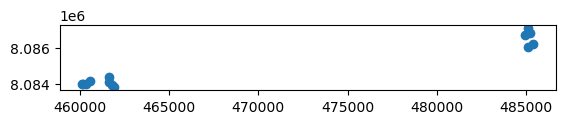

In [16]:
puntos_indi.plot()

In [17]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [18]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [19]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
691,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L17.3,4.269434,0.0,50,"POLYGON ((460144.502 8083926.387, 460258.298 8..."
1030,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L18.3,7.041418,0.0,50,"POLYGON ((460479.368 8084018.464, 460496.530 8..."
1033,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L15.2,5.451087,0.0,50,"POLYGON ((461383.623 8084325.034, 461565.739 8..."
1034,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L10.2,2.890233,0.0,50,"POLYGON ((461830.345 8083821.373, 461796.555 8..."
1066,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L13,4.448583,0.0,50,"POLYGON ((461508.101 8084136.836, 461745.798 8..."
1338,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L17.1.2,0.714091,0.0,50,"POLYGON ((460164.548 8083944.338, 460099.635 8..."
1350,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L17.1.3,0.571920,0.0,50,"POLYGON ((460251.436 8084001.452, 460166.134 8..."
8053,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L10.1,4.714146,9.0,50,"POLYGON ((461830.345 8083821.373, 461878.508 8..."
10729,220.0,SANTA BARBARA--CRONENBOLD ROBERTO,2641.0,CRONENBOLD AGUILERA ROBERTO,L2,24.867379,1.0,50,"POLYGON ((484823.611 8086417.989, 484804.116 8..."
10732,220.0,SANTA BARBARA--CRONENBOLD ROBERTO,2641.0,CRONENBOLD AGUILERA ROBERTO,L4,23.868844,1.0,50,"POLYGON ((485201.350 8086420.963, 485274.282 8..."


In [20]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [21]:
poligonos_intersect_cat.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
691,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L17.3,4.269434,0.0,50,"POLYGON ((460144.502 8083926.387, 460258.298 8..."
1030,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L18.3,7.041418,0.0,50,"POLYGON ((460479.368 8084018.464, 460496.530 8..."
1033,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L15.2,5.451087,0.0,50,"POLYGON ((461383.623 8084325.034, 461565.739 8..."


In [22]:
# agrega los campos faltantes
poligonos_intersect_cat['os'] = ors

In [23]:
plan = poligonos_intersect_cat.copy()

In [24]:
plan.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os
691,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L17.3,4.269434,0.0,50,"POLYGON ((460144.502 8083926.387, 460258.298 8...",17
1030,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L18.3,7.041418,0.0,50,"POLYGON ((460479.368 8084018.464, 460496.530 8...",17
1033,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L15.2,5.451087,0.0,50,"POLYGON ((461383.623 8084325.034, 461565.739 8...",17


<Axes: >

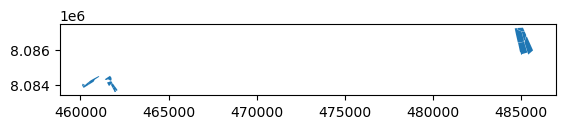

In [25]:
plan.plot()

In [26]:
plan['area'].sum()

116.10553001896547

In [27]:
#RECALCULAR EL AREA
plan['area'] = plan.geometry.area / 10000

In [28]:
plan['area'].sum()

117.20435230949013

In [29]:
# carga el shp de planificacion
gdf_plan = gpd.read_file(path_plan)

In [30]:
# determina el ultimo id
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [31]:
last_id

223

In [32]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [33]:
plan.head(3)

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
691,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L17.3,4.269434,0.0,50,"POLYGON ((460144.502 8083926.387, 460258.298 8...",17,224
1030,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L18.3,7.041418,0.0,50,"POLYGON ((460479.368 8084018.464, 460496.530 8...",17,225
1033,375.0,SANTA ANITA--GUILLERMO SANTIAGO,18027.0,AGUILERA TARRADELLES GUILLERMO,L15.2,5.451087,0.0,50,"POLYGON ((461383.623 8084325.034, 461565.739 8...",17,226


In [34]:
len(plan)

13

In [35]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

In [36]:
gdf_pla_gral['area'].sum()

2174.0704624729015

In [37]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [38]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,os,soca,id,inst,idd,geometry
0,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L31,30.260942,1,2,1,50,1.0,"POLYGON ((504085.659 8094406.031, 503737.808 8..."
1,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L16,23.216246,1,4,2,50,1.0,"POLYGON ((504352.053 8094797.970, 504272.088 8..."
2,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,ER-L6,19.683505,1,5,3,50,1.0,"POLYGON ((503260.583 8094596.306, 503714.735 8..."
3,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L35,7.795719,1,4,4,50,1.0,"POLYGON ((504693.348 8094607.629, 504673.327 8..."
4,30,CAMPO DULCE,41594,AGROPECUARIA CAMPO DULCE S.R.L.,EP-L34,7.048921,1,5,5,50,1.0,"POLYGON ((504137.327 8094415.183, 504648.080 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...
205,220,SANTA BARBARA--CRONENBOLD ROBERTO,2641,CRONENBOLD AGUILERA ROBERTO,L2,25.497528,17,1,232,50,NaN,"POLYGON ((484823.611 8086417.989, 484804.116 8..."
206,220,SANTA BARBARA--CRONENBOLD ROBERTO,2641,CRONENBOLD AGUILERA ROBERTO,L4,23.868844,17,1,233,50,NaN,"POLYGON ((485201.350 8086420.963, 485274.282 8..."
207,220,SANTA BARBARA--CRONENBOLD ROBERTO,2641,CRONENBOLD AGUILERA ROBERTO,L6,7.740109,17,1,234,50,NaN,"POLYGON ((485045.039 8087027.865, 485215.254 8..."
208,220,SANTA BARBARA--CRONENBOLD ROBERTO,2641,CRONENBOLD AGUILERA ROBERTO,L1,24.173261,17,1,235,50,NaN,"POLYGON ((484947.043 8085884.653, 484840.149 8..."


In [39]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

# CARGAR PLANIFICACION A AMIGOCLOUD

In [40]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [41]:
# repreyectar a WGS84
gdf_pla_gral = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [42]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [43]:
len(gdf_pla_gral)

13

In [45]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/35248/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_360912 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CARGAR XLSX

In [46]:
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

In [47]:
# Cargar el archivo Excel
sheet_name = 'DATA'
table_name = 'tbl_data'

In [48]:
excel_data = pd.read_excel(path_xlsx_parte)

In [49]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,os,id
691,375,SANTA ANITA--GUILLERMO SANTIAGO,18027,AGUILERA TARRADELLES GUILLERMO,L17.3,4.269434,0,50,"MULTIPOLYGON (((-63.37509 -17.32975, -63.37402...",17,224
1030,375,SANTA ANITA--GUILLERMO SANTIAGO,18027,AGUILERA TARRADELLES GUILLERMO,L18.3,7.041418,0,50,"MULTIPOLYGON (((-63.37194 -17.32893, -63.37177...",17,225
1033,375,SANTA ANITA--GUILLERMO SANTIAGO,18027,AGUILERA TARRADELLES GUILLERMO,L15.2,5.451087,0,50,"MULTIPOLYGON (((-63.36342 -17.32617, -63.36170...",17,226
1034,375,SANTA ANITA--GUILLERMO SANTIAGO,18027,AGUILERA TARRADELLES GUILLERMO,L10.2,2.890233,0,50,"MULTIPOLYGON (((-63.35923 -17.33073, -63.35954...",17,227
1066,375,SANTA ANITA--GUILLERMO SANTIAGO,18027,AGUILERA TARRADELLES GUILLERMO,L13,4.448583,0,50,"MULTIPOLYGON (((-63.36225 -17.32788, -63.36001...",17,228
1338,375,SANTA ANITA--GUILLERMO SANTIAGO,18027,AGUILERA TARRADELLES GUILLERMO,L17.1.2,0.714091,0,50,"MULTIPOLYGON (((-63.37490 -17.32959, -63.37551...",17,229
1350,375,SANTA ANITA--GUILLERMO SANTIAGO,18027,AGUILERA TARRADELLES GUILLERMO,L17.1.3,0.571920,0,50,"MULTIPOLYGON (((-63.37408 -17.32908, -63.37489...",17,230
8053,375,SANTA ANITA--GUILLERMO SANTIAGO,18027,AGUILERA TARRADELLES GUILLERMO,L10.1,4.714146,9,50,"MULTIPOLYGON (((-63.35923 -17.33073, -63.35877...",17,231
10729,220,SANTA BARBARA--CRONENBOLD ROBERTO,2641,CRONENBOLD AGUILERA ROBERTO,L2,25.497528,1,50,"MULTIPOLYGON (((-63.14281 -17.30753, -63.14300...",17,232
10732,220,SANTA BARBARA--CRONENBOLD ROBERTO,2641,CRONENBOLD AGUILERA ROBERTO,L4,23.868844,1,50,"MULTIPOLYGON (((-63.13926 -17.30751, -63.13857...",17,233


In [50]:
new_data = {
    'INSTITUCION':list(gdf_pla_gral['inst']), 
    'COD CANERO': list(gdf_pla_gral['unidad_03']),
    'NOMBRE CANERO': list(gdf_pla_gral['unidad_04']),
    'COD PROPIEDAD': list(gdf_pla_gral['unidad_01']),
    'NOMBRE PROPIEDAD': list(gdf_pla_gral['unidad_02']),
    'LOTE': list(gdf_pla_gral['unidad_05']),
    'HECTAREA': list(gdf_pla_gral['area']),
    'CICLO': list(gdf_pla_gral['soca']),
    'ID': list(gdf_pla_gral['id']),
    'OS': list(gdf_pla_gral['os'])
}

new_df = pd.DataFrame(new_data)

In [51]:
new_df.head(3)

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS
0,50,18027,AGUILERA TARRADELLES GUILLERMO,375,SANTA ANITA--GUILLERMO SANTIAGO,L17.3,4.269434,0,224,17
1,50,18027,AGUILERA TARRADELLES GUILLERMO,375,SANTA ANITA--GUILLERMO SANTIAGO,L18.3,7.041418,0,225,17
2,50,18027,AGUILERA TARRADELLES GUILLERMO,375,SANTA ANITA--GUILLERMO SANTIAGO,L15.2,5.451087,0,226,17


In [52]:
# extrae los valores de Nº DE LABOR, convierte a conjunto y luego a lista
lista_cite = list(set(excel_data['Nº DE LABOR']))

In [53]:
# extrae los valores numericos de cada Nº DE LABOR
lista_num = [int(i.split('-')[-1]) for i in lista_cite]
lista_num

[17,
 1,
 31,
 25,
 29,
 11,
 35,
 33,
 27,
 5,
 34,
 36,
 20,
 19,
 10,
 37,
 6,
 30,
 40,
 26,
 8,
 12,
 22,
 13,
 9,
 39,
 2,
 18,
 15,
 21,
 32,
 38,
 14,
 4]

In [54]:
next_num_labor = max(lista_num) + 1
next_num_labor

41

In [55]:
new_df['MEZCLA'] = 0
new_df['LABOR_REALIZADA'] = 'PUL. CON DRONE'
new_df['Nº DE LABOR'] = 'PA-2025-' + str(next_num_labor)

In [56]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,ID,OS,MEZCLA,LABOR_REALIZADA,Nº DE LABOR
0,50,18027,AGUILERA TARRADELLES GUILLERMO,375,SANTA ANITA--GUILLERMO SANTIAGO,L17.3,4.269434,0,224,17,0,PUL. CON DRONE,PA-2025-41
1,50,18027,AGUILERA TARRADELLES GUILLERMO,375,SANTA ANITA--GUILLERMO SANTIAGO,L18.3,7.041418,0,225,17,0,PUL. CON DRONE,PA-2025-41
2,50,18027,AGUILERA TARRADELLES GUILLERMO,375,SANTA ANITA--GUILLERMO SANTIAGO,L15.2,5.451087,0,226,17,0,PUL. CON DRONE,PA-2025-41
3,50,18027,AGUILERA TARRADELLES GUILLERMO,375,SANTA ANITA--GUILLERMO SANTIAGO,L10.2,2.890233,0,227,17,0,PUL. CON DRONE,PA-2025-41
4,50,18027,AGUILERA TARRADELLES GUILLERMO,375,SANTA ANITA--GUILLERMO SANTIAGO,L13,4.448583,0,228,17,0,PUL. CON DRONE,PA-2025-41
5,50,18027,AGUILERA TARRADELLES GUILLERMO,375,SANTA ANITA--GUILLERMO SANTIAGO,L17.1.2,0.714091,0,229,17,0,PUL. CON DRONE,PA-2025-41
6,50,18027,AGUILERA TARRADELLES GUILLERMO,375,SANTA ANITA--GUILLERMO SANTIAGO,L17.1.3,0.571920,0,230,17,0,PUL. CON DRONE,PA-2025-41
7,50,18027,AGUILERA TARRADELLES GUILLERMO,375,SANTA ANITA--GUILLERMO SANTIAGO,L10.1,4.714146,9,231,17,0,PUL. CON DRONE,PA-2025-41
8,50,2641,CRONENBOLD AGUILERA ROBERTO,220,SANTA BARBARA--CRONENBOLD ROBERTO,L2,25.497528,1,232,17,0,PUL. CON DRONE,PA-2025-41
9,50,2641,CRONENBOLD AGUILERA ROBERTO,220,SANTA BARBARA--CRONENBOLD ROBERTO,L4,23.868844,1,233,17,0,PUL. CON DRONE,PA-2025-41


In [57]:
final_data = pd.concat([excel_data, new_df], ignore_index=True)

In [58]:
final_data.to_excel(path_xlsx_parte, index=False)